In [1]:
### FUNCTION DEFINITION BLOCK ###

# Read the modeling data from the CSV file
def get_Strategic_Subject_List_Data():
    raw_data = pd.read_csv("Strategic_Subject_List.csv", low_memory = False)
    #Replace spaces in column names by underscore
    raw_data.columns = [x.strip().replace(' ', '_') for x in raw_data.columns]
    #Replace the blank values with NAN 
    raw_data.replace(r'^\s+$', np.nan, regex=True, inplace = True)
    return(raw_data)
# Used the 8 predictors as mentioned in the SSL project on website
def feature_selection(raw_data):
    final_features = raw_data[['SSL_SCORE','PREDICTOR_RAT_AGE_AT_LATEST_ARREST',
                               'SEX_CODE_CD','RACE_CODE_CD','WEAPON_I',
                               'DRUG_I','CPD_ARREST_I','LATEST_DIST']]
    return(final_features)

In [3]:
#### EXPLORATORY DATA ANALYSIS  ### 

# Importing the required libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn import preprocessing


#Adjusting the display options of Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#Importing the python matplot library for exploratory data analysis
import matplotlib.pyplot as plt
import pandas as pd

# Import the raw data from the csv file
raw_data = get_Strategic_Subject_List_Data()

# Selecting final features for the model
final_features = feature_selection(raw_data)

In [17]:
# Changing the data type of LATEST_DIST to object as it is categorical variable
final_features['LATEST_DIST'] = final_features.LATEST_DIST.astype(str)

In [18]:
final_features.dtypes

SSL_SCORE                              int64
PREDICTOR_RAT_AGE_AT_LATEST_ARREST    object
SEX_CODE_CD                           object
RACE_CODE_CD                          object
WEAPON_I                              object
DRUG_I                                object
CPD_ARREST_I                          object
LATEST_DIST                           object
dtype: object

In [28]:
### Data Processing Block ###
# Segregating the Categorical and Numerical Variables
categorical = final_features.select_dtypes(include=['object'])
numeric = final_features.select_dtypes(exclude=['object'])

#Defining the Dummy variables for the categorical variables 
for name, values in categorical.items():
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=False)
    numeric = pd.concat([numeric, dummies], axis=1)
    
#Imputing the missing values  
for name in numeric:
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)

In [29]:
# Defining the target variable and independent variables

y = numeric['SSL_SCORE']
X = numeric.drop(['SSL_SCORE'], axis = 1)

# Creating a Holdout for Testing of 20%
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from sklearn.ensemble import ExtraTreesRegressor
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
feature_names = X.columns
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



Feature ranking:
1. feature 0 (0.428658)
2. feature 6 (0.306450)
3. feature 1 (0.174975)
4. feature 2 (0.056337)
5. feature 3 (0.013937)
6. feature 18 (0.004150)
7. feature 17 (0.003838)
8. feature 4 (0.002105)
9. feature 20 (0.001275)
10. feature 19 (0.001218)
11. feature 22 (0.001217)
12. feature 11 (0.001174)
13. feature 21 (0.001143)
14. feature 8 (0.000778)
15. feature 39 (0.000337)
16. feature 15 (0.000215)
17. feature 16 (0.000179)
18. feature 5 (0.000169)
19. feature 7 (0.000157)
20. feature 28 (0.000134)
21. feature 25 (0.000119)
22. feature 24 (0.000093)
23. feature 23 (0.000089)
24. feature 43 (0.000082)
25. feature 32 (0.000080)
26. feature 40 (0.000077)
27. feature 31 (0.000075)
28. feature 36 (0.000075)
29. feature 44 (0.000067)
30. feature 45 (0.000065)
31. feature 38 (0.000063)
32. feature 26 (0.000062)
33. feature 33 (0.000060)
34. feature 30 (0.000059)
35. feature 41 (0.000059)
36. feature 37 (0.000054)
37. feature 27 (0.000053)
38. feature 14 (0.000050)
39. feature 1

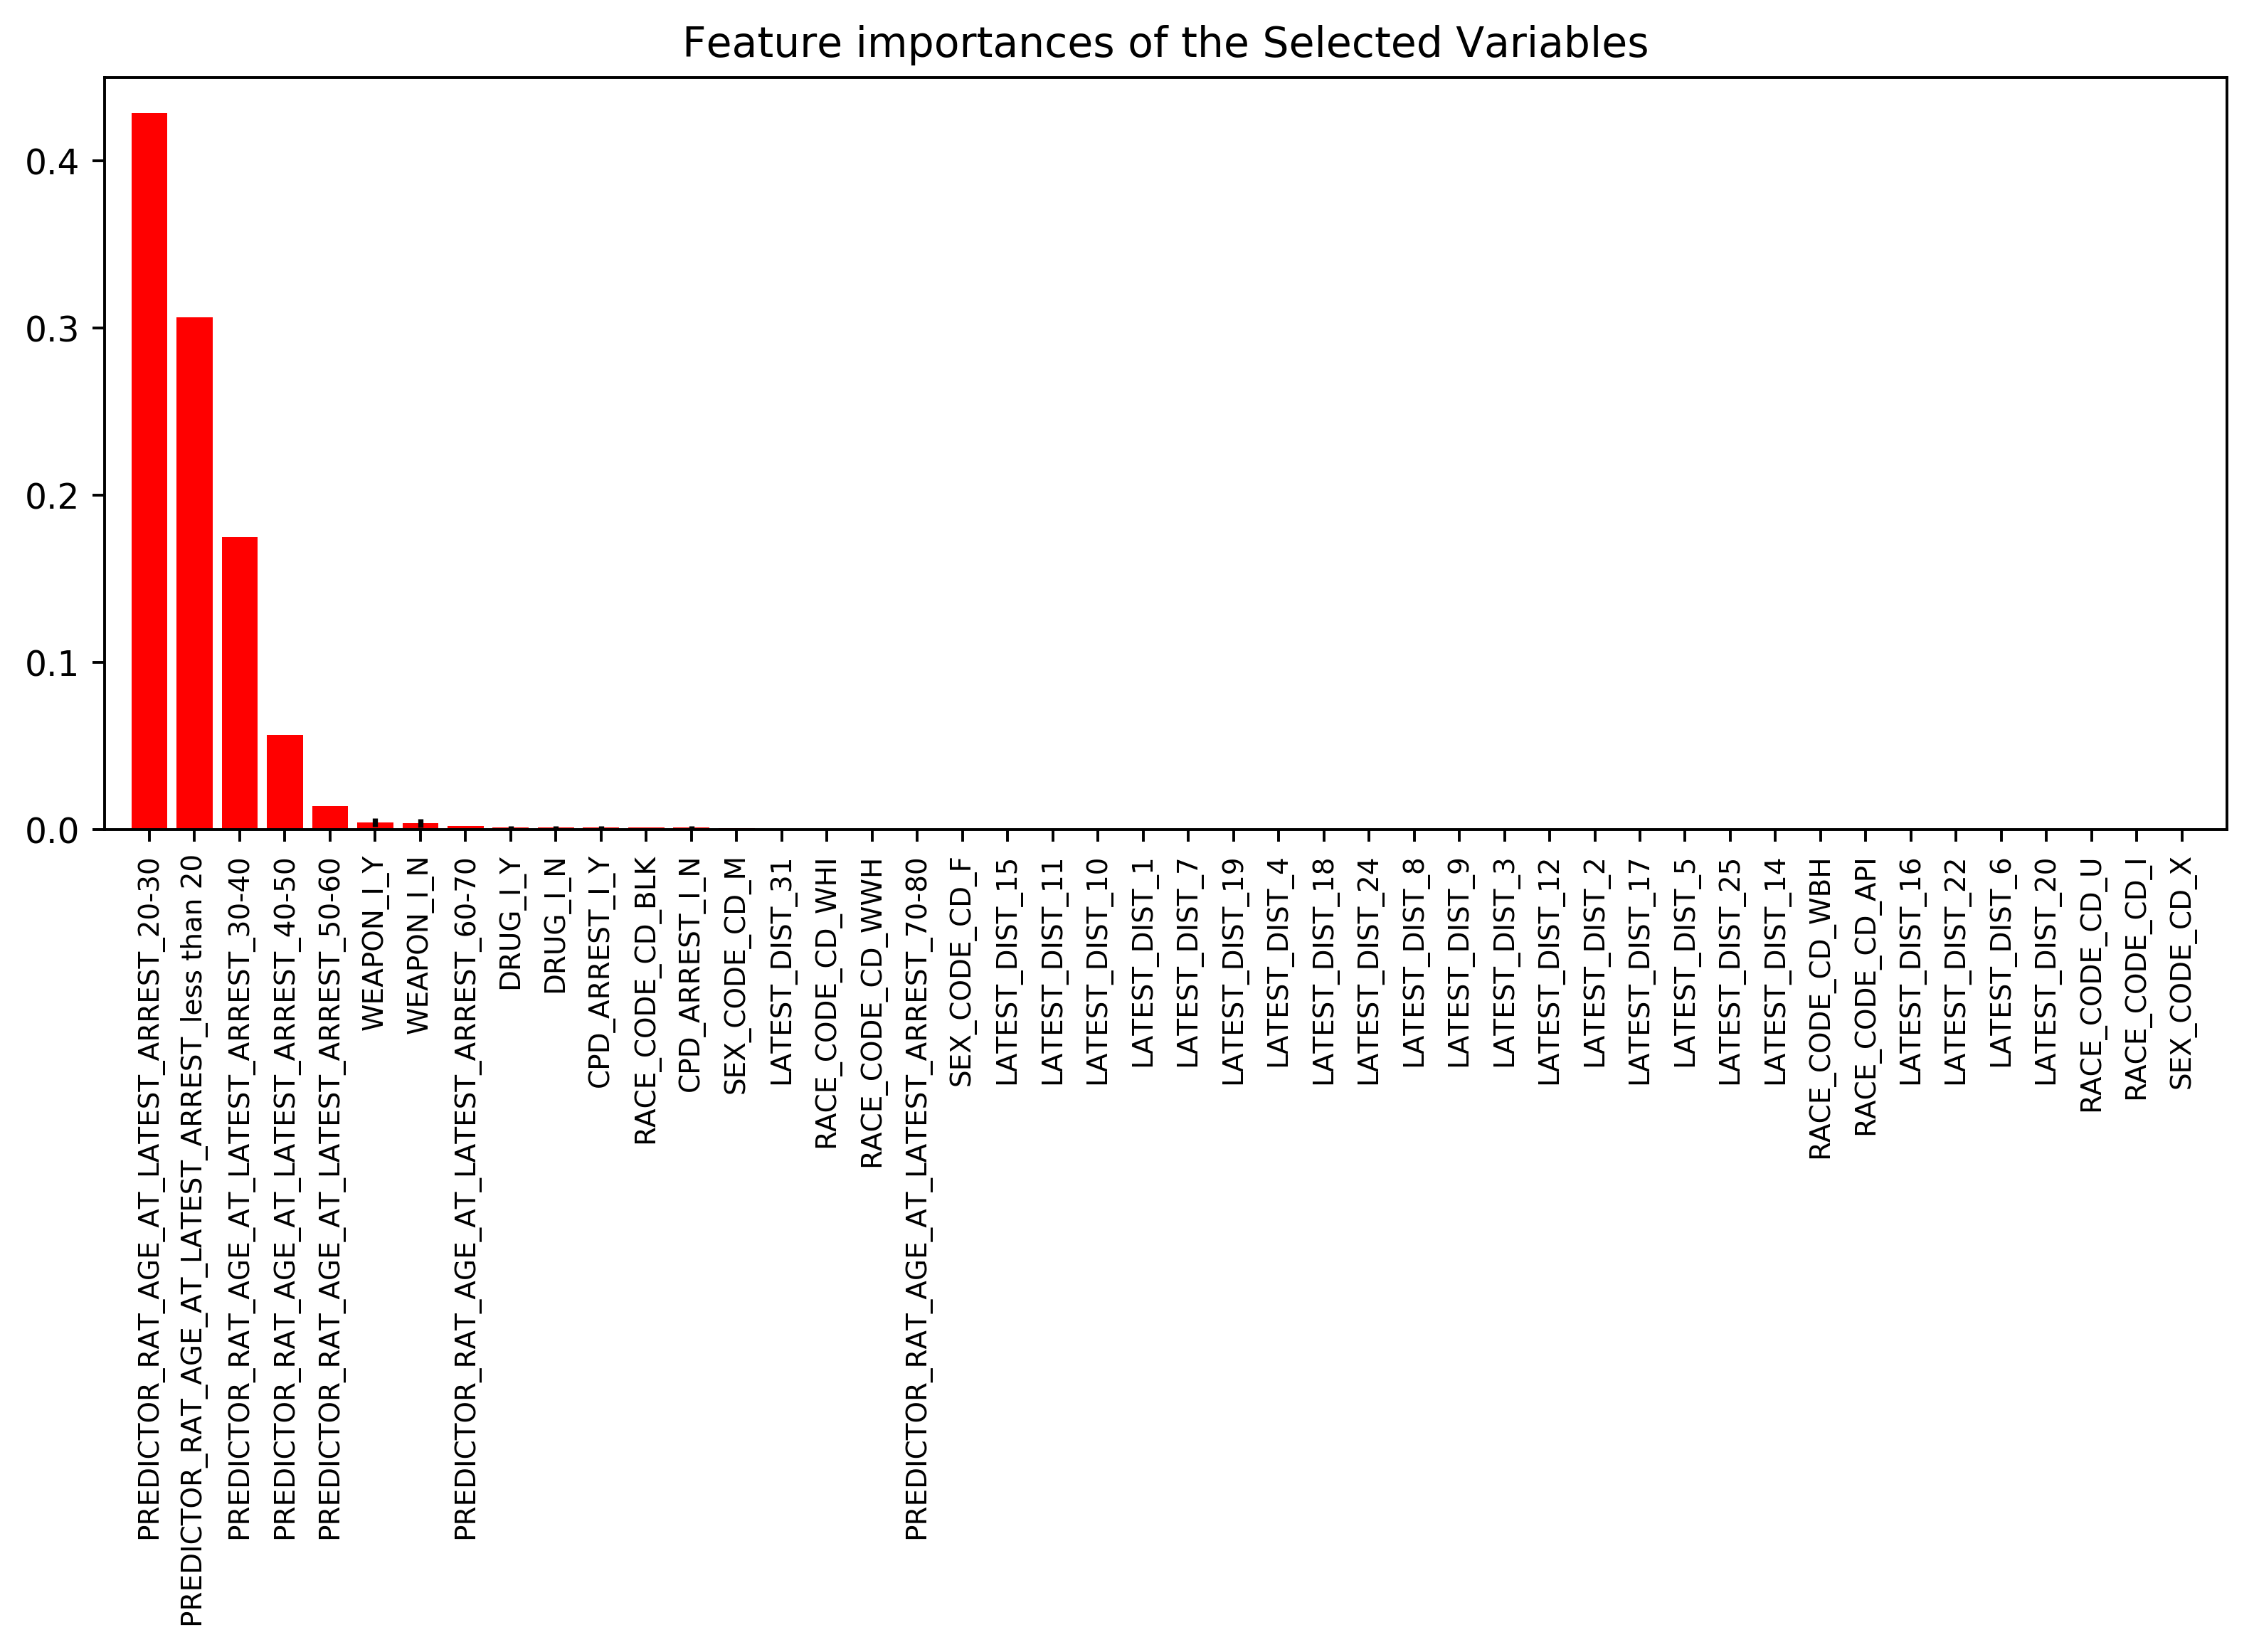

In [37]:
# Plot the feature importances of the forest
plt.figure(figsize=(11, 4), dpi=350)
plt.title("Feature importances of the Selected Variables")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices],rotation=90,size=8)
plt.xlim([-1, X.shape[1]])
plt.show()

In [33]:
# GLM Ridge model using sk-learn ##
from sklearn import linear_model
reg = linear_model.Ridge()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', reg) ])
# Parameter tuning
alpha=[0.005]

from sklearn.model_selection import GridSearchCV
optimized_reg = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__alpha = alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_reg.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__alpha': [0.005]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [34]:
## Evaluating GLM - Ridge Regression on Holdout - Test Data, using mean_squared_error metrics ##
from sklearn.metrics import mean_squared_error
y_pred = optimized_reg.predict(X_test)
print("The Mean Squared Error Using GLM - Ridge is : ",mean_squared_error(y_test, y_pred))

The Mean Squared Error Using GLM - Ridge is :  331.667436797


In [35]:
## Evaluating GLM - Ridge Regression on Holdout - Test Data, using R2 Metrics ##
from sklearn.metrics import r2_score
y_pred = optimized_reg.predict(X_test)
print("The R2 Using GLM - Ridge is :",r2_score(y_test, y_pred))

The R2 Using GLM - Ridge is : 0.900718363431


In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', gbr) ])

# Parameters for tuning the model
gbc_learning_rate = [0.1,0.01]
gbc_max_depth = [4, 6]
gbc_min_samples_leaf = [3, 5]
gbm_max_features = [1.0, 0.1]

#Implementing GridSearchCV
from sklearn.model_selection import GridSearchCV
optimized_gbr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__learning_rate= gbc_learning_rate, 
                                              model__max_depth = gbc_max_depth,
                                              model__min_samples_leaf = gbc_min_samples_leaf,
                                              model__max_features = gbm_max_features)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1)

#Fitting the model with Grid Search
optimized_gbr.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 63.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__max_depth': [4, 6], 'model__max_features': [1.0, 0.1], 'model__learning_rate': [0.1, 0.01], 'model__min_samples_leaf': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [38]:
## Evaluating GBM on Holdout - Test Data ##
from sklearn.metrics import mean_squared_error
y_pred = optimized_gbr.predict(X_test)
print("The Mean Squared Error Using GBM Regressor is : ",mean_squared_error(y_test, y_pred))

The Mean Squared Error Using GBM Regressor is :  323.669612117


In [39]:
#Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', rfr) ])


# Parameters for tuning the model
tree_depth = [5,6]
tree_min_samples_split = [5, 10]
tree_min_samples_leaf = [5, 10]
tree_max_leaf_nodes = [10,15]
#Implementing GridSearchCV
from sklearn.model_selection import GridSearchCV
optimized_rfr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__max_depth= tree_depth, 
                                              model__min_samples_split = tree_min_samples_split,
                                              model__min_samples_leaf = tree_min_samples_leaf,
                                              model__max_leaf_nodes = tree_max_leaf_nodes)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1)

#Fitting the model with Grid Search
optimized_rfr.fit(X_train, y_train)
print("The best estimator : ", optimized_rfr.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished


The best estimator :  Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=15,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])


In [40]:
## Evaluating Random Forest Regressor on Holdout - Test Data ##
from sklearn.metrics import mean_squared_error
y_pred = optimized_rfr.predict(X_test)
print("The Mean Squared Error Using Random Forest Regressor is : ",mean_squared_error(y_test, y_pred))

The Mean Squared Error Using Random Forest Regressor is :  333.785224258


In [41]:
## XGB Regressor Model  ##
import xgboost as xgb
xg = xgb.XGBRegressor()
# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', xg) ])

# Parameters for tuning the model
#gbc_learning_rate = [0.1,0.01]
max_depth = [4, 6,8]
n_estimators = [50, 100,150]

#Implementing GridSearchCV
from sklearn.model_selection import GridSearchCV
optimized_xg = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__max_depth = max_depth,
                                              model__n_estimators = n_estimators)
                                             # model__max_features = gbm_max_features)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1)

#Fitting the model with Grid Search
optimized_xg.fit(X_train, y_train)
print("The best estimator : ", optimized_xg.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 25.3min finished


The best estimator :  Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])


In [42]:
## Evaluating XGB Regressor on Holdout - Test Data ##
from sklearn.metrics import mean_squared_error
y_pred = optimized_xg.predict(X_test)
print("The Mean Squared Error Using XGBoost Regressor is : ",mean_squared_error(y_test, y_pred))

The Mean Squared Error Using XGBoost Regressor is :  323.495952131
